# Implementing coordinate-transformed hermite polynomials

In [1]:
from sympy.parsing import mathematica as mc
from numpy import sin as sin
import re
import PauLisa as pl, PL_Plot as plplt,plback as plb, Tophat_integration_AW as th, numpy as np, matplotlib.pyplot as plt, cmath as cm
#import signals_calc as sig

from numpy import pi as pi
from numpy import angle
#from numpy import sqrt as sqrt
from scipy.special import erf as erf
import mpmath as mp
import scipy.io

from math import pi, log, exp, sin, cos, atan, e, radians, degrees
from scipy.special import gamma as gamma
from scipy.special import erf as erf
from scipy.special import comb

from math import factorial as Factorial
import cmath
from cmath import sqrt as Sqrt
import numpy as np

from time import process_time

inf=np.inf

import pandas as pd
from pprint import pprint
from copy import copy as cp

#progress bar
import time
from progressbar import AnimatedMarker, Bar, BouncingBar, Counter, ETA, \
    AdaptiveETA, FileTransferSpeed, FormatLabel, Percentage, \
    ProgressBar, ReverseBar, RotatingMarker, \
    SimpleProgress, Timer, UnknownLength



In [2]:
#order a^#*b^#
working = 2
crossterm_order = working+1

In [3]:
# 1. Mathematica solution 
mat_sol_arr = [None]*crossterm_order
for f in range(crossterm_order):
    file = open(str(f)+".txt")

    line = file.read().replace("\n", " ")
    file.close()

#     print(line)
    print(f)
    mat_sol_arr[f] = line

mat_sol=mat_sol_arr[working]

0
1
2


In [4]:
# 2. Parse for Python

# parse solution from Mathematica FortranForm
# pars_sol=mc.mathematica(mat_sol)
# print(pars_sol)

str_pars_sol = str(mat_sol) #entire solution as string



# print(str_pars_sol.split(' '))
sol_list = str_pars_sol.split(" ") # split by whitespace



#remove '+', prepend '-'
for i in range(len(sol_list)):
    j = sol_list[i]
    if(j == '-'):
        sol_list[i+1]= '-' + sol_list[i+1]



# whitespace in Factorial(...) interferes w/ strip
## Example:
## (-8*a*b**3*p**4*z**3*Sqrt(Factorial(-4 + n)))/(3.*w**4)
## -> ["(z**3*Sqrt(Factorial(-4", "n)))/(3.*w**4)" ]
## 1) "(z**3*Sqrt(Factorial(-4" -> "(z**3*Sqrt(Factorial("
## 2) "n)))/(3.*w**4)" -> ")))/(3.*w**4)" 
## 3) -> ["(z**3*Sqrt(Factorial(n-4)))/(3.*w**4)" ]

#build list of terms, where operators +,-, whitespace deleted
sol_list[:] = [i for i in sol_list if i not in ['-', '+', '']] 

def parse_factorial(sol_list):
    for i in sol_list:
        if 'Factorial' in i:
            current_index = sol_list.index(i) #index with factorial
            next_index = current_index+1
            n_minus = 'n-' + i[-1]
            sol_list[current_index] = sol_list[current_index][:-2] + n_minus +  sol_list[next_index][1:]
            del sol_list[next_index]

parse_factorial(sol_list)

            
print("Terms list:", sol_list)

Terms list: ['1', '-a*b*j*K', '(a**2*b**2*j**2*K**2)/2.', '-(a**2*j*K)/(2.*R)', '(a**2*b**2*j*K)/(2.*R)', '-a**2/w**2', '(a**2*b**2)/w**2', 'b*j*K*x', '-a*b**2*j**2*K**2*x', '(a*j*K*x)/R', '-(a*b**2*j*K*x)/R', '-(3*a**2*b*j**2*K**2*x)/(2.*R)', '(2*a*x)/w**2', '-(2*a*b**2*x)/w**2', '-(3*a**2*b*j*K*x)/w**2', '(b**2*j**2*K**2*x**2)/2.', '(a**2*j**2*K**2*x**2)/(2.*R**2)', '-(5*a**2*b**2*j**2*K**2*x**2)/(4.*R**2)', '(b**2*j*K*x**2)/(2.*R)', '(a*b*j**2*K**2*x**2)/R', '-(5*a**2*b**2*j**3*K**3*x**2)/(4.*R)', '(2*a**2*x**2)/w**4', '-(5*a**2*b**2*x**2)/w**4', '(b**2*x**2)/w**2', '(2*a*b*j*K*x**2)/w**2', '-(5*a**2*b**2*j**2*K**2*x**2)/(2.*w**2)', '(2*a**2*j*K*x**2)/(R*w**2)', '-(5*a**2*b**2*j*K*x**2)/(R*w**2)', '(a*b**2*j**2*K**2*x**3)/(2.*R**2)', '(a**2*b*j**3*K**3*x**3)/(2.*R**2)', '(a*b**2*j**3*K**3*x**3)/(2.*R)', '(2*a*b**2*x**3)/w**4', '(2*a**2*b*j*K*x**3)/w**4', '(a*b**2*j**2*K**2*x**3)/w**2', '(2*a*b**2*j*K*x**3)/(R*w**2)', '(2*a**2*b*j**2*K**2*x**3)/(R*w**2)', '(a**2*b**2*j**3*K**3*x**4)/

In [5]:
#3. Separate terms list for x-coordinate dependence

#get highest n for x**n
rows, cols = (5, 5) 
sols_matrix = [ [ '' for i in range(rows) ] for j in range(cols) ]

#remove x**n and put term into sol_list[n]
for i in sol_list:
    x_order=0; p_order = 0
    #if x -> arr[n]
    #nonlinear
    if('x**' in i):
        exp_ind=i.find('x')+3 #get exp index
        x_order = int(i[exp_ind]) #set x order
    #no x -> arr[0]
    elif(not 'x' in i):
        x_order = 0
        #linear 
    else:
        x_order = 1
        
    #if x -> arr[n]
    #nonlinear
    if('p**' in i):
        exp_ind=i.find('p')+3 #get exp index
        p_order = int(i[exp_ind]) #set x order
    #no x -> arr[0]
    elif(not 'p' in i):
        p_order = 0
        #linear 
    else:
        p_order = 1
        
    sols_matrix[x_order][p_order] += '+' + i  
    print(i,x_order,p_order)

    

    
# for row in range(rows):
#     for col in range(cols):
#         print(sols_matrix[row][col],row,col)

# print(sols_matrix)

1 0 0
-a*b*j*K 0 0
(a**2*b**2*j**2*K**2)/2. 0 0
-(a**2*j*K)/(2.*R) 0 0
(a**2*b**2*j*K)/(2.*R) 0 0
-a**2/w**2 0 0
(a**2*b**2)/w**2 0 0
b*j*K*x 1 0
-a*b**2*j**2*K**2*x 1 0
(a*j*K*x)/R 1 0
-(a*b**2*j*K*x)/R 1 0
-(3*a**2*b*j**2*K**2*x)/(2.*R) 1 0
(2*a*x)/w**2 1 0
-(2*a*b**2*x)/w**2 1 0
-(3*a**2*b*j*K*x)/w**2 1 0
(b**2*j**2*K**2*x**2)/2. 2 0
(a**2*j**2*K**2*x**2)/(2.*R**2) 2 0
-(5*a**2*b**2*j**2*K**2*x**2)/(4.*R**2) 2 0
(b**2*j*K*x**2)/(2.*R) 2 0
(a*b*j**2*K**2*x**2)/R 2 0
-(5*a**2*b**2*j**3*K**3*x**2)/(4.*R) 2 0
(2*a**2*x**2)/w**4 2 0
-(5*a**2*b**2*x**2)/w**4 2 0
(b**2*x**2)/w**2 2 0
(2*a*b*j*K*x**2)/w**2 2 0
-(5*a**2*b**2*j**2*K**2*x**2)/(2.*w**2) 2 0
(2*a**2*j*K*x**2)/(R*w**2) 2 0
-(5*a**2*b**2*j*K*x**2)/(R*w**2) 2 0
(a*b**2*j**2*K**2*x**3)/(2.*R**2) 3 0
(a**2*b*j**3*K**3*x**3)/(2.*R**2) 3 0
(a*b**2*j**3*K**3*x**3)/(2.*R) 3 0
(2*a*b**2*x**3)/w**4 3 0
(2*a**2*b*j*K*x**3)/w**4 3 0
(a*b**2*j**2*K**2*x**3)/w**2 3 0
(2*a*b**2*j*K*x**3)/(R*w**2) 3 0
(2*a**2*b*j**2*K**2*x**3)/(R*w**2) 3 0
(a**2

In [6]:
#4. Separate terms list for coord.-transformed hermite poly

#get highest n for p**n
# herm_arr = ['']*rows


# #remove p**n and put term into herm_arr[n]
# for i in sol_list:
#     #if x -> arr[n]
#     #nonlinear
#     if('p**' in i):
#         n_ind=i.find('p')+3 #get exp index
#         n = int(i[n_ind]) #set n to exp
#         herm_arr[n] += '+' + i #insert term at nth row of arr  
#     #no x -> arr[0]
#     elif(not 'p' in i):
#         herm_arr[0]+= '+' + i
#         #linear 
#     else:
#         herm_arr[1]+= '+' + i



In [7]:
#x dep
def x_plus_1(w0,z,zr,n):    
    factor = (w0/2)*( ( 1-(1j)*(z/zr) )*np.sqrt(n+1))
    return(factor)

#x dep
def x_minus_1(w0,z,zr,n):
    factor = (w0/2)*( np.sqrt(n)*(1+(1j)*(z/zr)) )
    return(factor)

In [8]:
#represents iterative x transformation
##starts at n-E
##iterates (c+d) times, this is x order
##returns a queue with X_{+/-}^1(n) for each n
#n start is n-e

class Item:
    def __init__(self, n,N,coeff):
        self.n = n
        self.N = N
        self.coeff = coeff

def transform_x (E,x_order, a,w,gouy,n, w0,z,zr):
    q1 = []
    q2 = []
    #queue of items which are passed each iteration
    coeff = 1 #coeff can be worked in this fxn, then multiplied to overall coupling after
    
    N = n-E #start at n-E
    
    start_item = Item(n,N,coeff)
    q1.append(start_item) #just for printing, need 3-array. to track inc/dec
    
    x_count = x_order  #counter to track iterations
    #print("n,E,N",n,E,N)
    
    #empty q1 iteratively and raise and lower
    while(x_count!=0):
        while(q1):
            #get from q1
            item = cp(q1.pop())
            
            #raise n, factor X_+^1(n)  **raising doesn't involve factor n**
            item_raise = cp(item)
            
            item_raise.coeff = item_raise.coeff*x_plus_1(w0,z,zr,item_raise.N)
            item_raise.N += 1 #overall n mode up
            
            
            q2.append(item_raise) # put into temp q
            
            
            #lower n, factor X_-^1(n)
            item_lower = cp(item)
            
            if(item_lower.N>0):
                item_lower.coeff = item_lower.coeff*x_minus_1(w0,z,zr,item_lower.N)
                item_lower.N -= 1 #overall n mode down

                q2.append(item_lower) #put into temp q
            
        #empty q2 back into q1 to re-iterate
        while(q2):
            q1.append(q2.pop())
            
        x_count-=1 #iteration done, decrement count
        
    
    #all x factors transformed, return full queue
    return(q1)

In [9]:
#represents the sums
def update_modes (z,params,a,b,modes,sols_matrix):
    #get params
    K = params.getK()
    w0 = params.getW0()
    zr = params.getZr()
    w = pl.w(z,params)
    gouy = pl.gouy_phase(z,params) 
    R = pl.radius_curvature(z,params)
    
    #build new modes (up to 2 orders larger for quad. dep.)
    rows = len(modes)
    cols = len(modes[0])  
    number_modes = rows*cols
    exp_order = len(sols_matrix)
    new_modes = [[0 for m in range(cols+exp_order)] for n in range(rows+exp_order)]
    
    #placeholders
    x=1
    j=1j
    p=e**(1j*gouy)
    
    #calculate all coupling factors a->e\d
       
    for n in range(len(modes)):
        for m in range(len(modes[n])):
            if (modes[n][m]!=0): #break if c_nm = 0
                c_nm = modes[n][m] #assign c_nm

                for x_order in range(len(sols_matrix[0])):
                    for p_order in range(len(sols_matrix)):
                        if(sols_matrix[x_order][p_order]!='' and (p_order<=n) ):
                            n_start = n-p_order
                            #append each element in x,p matrix to coupling list
                            coupling = eval(sols_matrix[x_order][p_order])*(p**(p_order))
                            #print(p_order,x_order,sols_matrix[x_order][p_order],coupling)

                            #do x transformation 
                            #start at n - [order of p], which x transformation depends on
                            
                            if(x_order>0):
                                q = transform_x(p_order,x_order,a,w,gouy,n,w0,z,zr)
                                #print(n_start,x_order)
                                #empty the q
                                while(q):
                                    item = cp(q.pop())
                                    X = item.coeff #just x coupling
                                    N = item.N #final n order
                                    #print("N,x_order,p_order,n,m",N,x_order,p_order,n,m)
                                    if(N>=0):
                                        new_modes[N][m]+= c_nm*coupling*X

                            #N is either n or n-p_order, no x-dependence
                            else:
                                N= n-p_order
                                #print("N,x_order,p_order,n,m",N,x_order,p_order,n,m)
                                new_modes[N][m]+= c_nm*coupling                            
# return(new_modes,ind_list)
    return(new_modes)

__header__
__version__
__globals__
coeftopUnitInt
coeftopUnitPow
readmepaul
['Two tophat coefficient variables, one for unit power and one for \n unit intensity, should be clear from the name which is which.\nAgain these assume a waist 1/3 of a mm.']


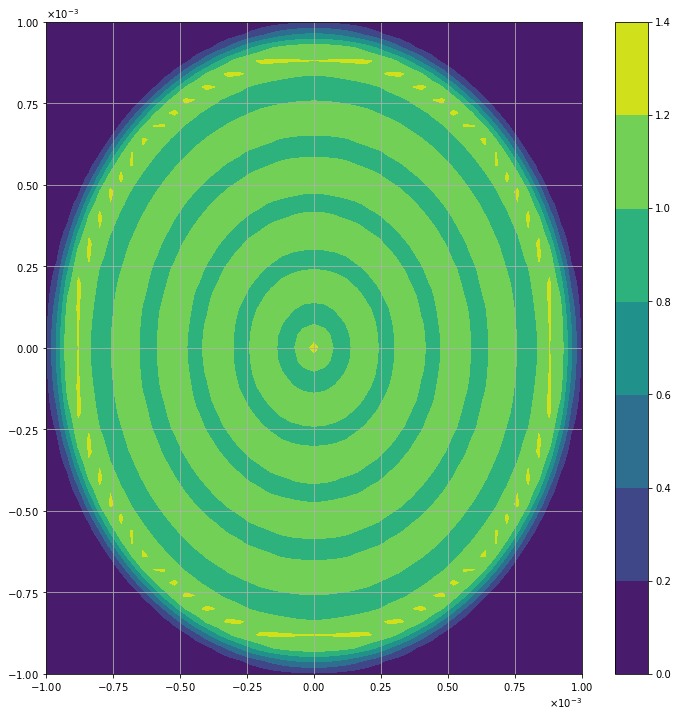

In [10]:
# mat = scipy.io.loadmat('Top_hat_for_paul.mat')
mat = scipy.io.loadmat('paul_coef_file.mat')
for x in mat:
  print(x)
coef=mat['coeftopUnitInt'].ravel()
print(mat['readmepaul'])
# coef=mat['coeftop'].ravel()

def N_f(A):
    
    res = np.floor((np.sqrt(8*A+1)-1)/2)
    
    #res = (np.sqrt(9+8*A)-3)/2
    return(res)

def m(N,A):
    res = (N+1)*(N+2)/2 - (A+1)
    return(res)

#def n(N,A):
#    m= (N+1)*(N+2)/2 - (A+1)
#    res = N-m
#    return(res)
def n(N,A):
    res = A - (N*(N+1)/2)
    return(res)

NumberModes = int(len(coef))
listModesN = [None] * NumberModes
listModesM = [None] * NumberModes
listModesC = [None] * NumberModes

area = pi*1e-3**2

#for i in range(len(coef)):
#    A=i
#    N= N_f(A)
#
#    if (m(N,A)%2 == 0) & (n(N,A)%2 == 0):
#        print(coef[A], '\t\t\t' , m(N,A), ',' , n(N,A))

for i in range(NumberModes):
    A=i
    N= N_f(A)
    listModesN[i] = int(m(N,A))
    listModesM[i] = int(n(N,A))
    listModesC[i] = coef[i]
    
top_modes = pl.create_modes(listModesM,listModesN,listModesC,NumberModes)

params = pl.Params(1064e-9,.33e-3,0)
plane = pl.Plane(-2e-3,2e-3,101,-2e-3,2e-3,101)
# temp_modes=rotate_RX(10e-3,params,10e-3,0,modes)
# pl.show_modes(modes)
calc=pl.calculate(params,plane,top_modes,0)
#plot
fig, ax = plt.subplots(figsize=(12, 12))
cs = plt.contourf(calc.plane.getX(), calc.plane.getY(), abs(calc.getAmp() ** 2))

ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)

plt.xlim([-1e-3,1e-3])
plt.ylim([-1e-3,1e-3])

cbar = fig.colorbar(cs)

plt.grid()


In [11]:
#loop through and sum over modes overlap where a,b -> n,m
def iterate_modes_overlap(w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,modes):   

    N = len(modes)
    M = len(modes[0])
    res_arr = [[0 for i in range(10)] for j in range(10)]
    res = 0

    for a in range(N):
        for b in range(M):            
            #ignore zero coeff.
            if (modes[a][b]!=0):
                c_nm = modes[a][b]
                #result is the sum of all overlap coefficients each with a factor of mode coefficient
                res += ( c_nm * th.overlap(a,b,w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y) )
                
    return(res)

In [12]:
def signals(v):
    #points determine size of arrays (equivalent to # data points plotted)
    points = v.points
    time_start = process_time()

    time_ave = 0

    #modes_arr = [0]*points
    cl = [0]*points
    cr = [0]*points
    phi_l = [0]*points
    phi_r = [0]*points
    dws = [0]*points
    lps = [0]*points
    total_lps = [0]*points


    #alpha_arr = np.linspace(-500e-6,500e-6,points)
    

    pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=points).start()

    
    
    for p in range(points):
        time_ave_start = process_time()
        #shift x+zsina
        new_modes = update_modes(v.z,v.params,v.a,v.alpha_arr[p],top_modes,sols_matrix)
       
        #create arrays of overlap coefficients left and right
        cl[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1L,v.x_2L,v.Z,v.Y,new_modes) # left overlap (-2e-3,0)

        cr[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1R,v.x_2R,v.Z,v.Y,new_modes) # right overlap (0,2e-3)
        time_ave += (process_time()-time_ave_start)

        #create arrays of phases for left and right coeff.
        phi_r[p]=angle(cr[p])
        phi_l[p]=angle(cl[p])
        
        #create arrays of dws &lps for phases in phase arrays
        dws[p] = (phi_r[p]-phi_l[p])
        lps[p] = 0.5*(phi_r[p]+phi_l[p])/v.k_1
        total_lps[p] = angle(cr[p]+cl[p])/v.k_1
        
        pbar.update(p+1)
        
    pbar.finish()
    
    #total time for all DWS & LPS points (not including scattering)
    time_elapsed = (process_time() - time_start)
    print(time_elapsed,'s')
    print(time_ave/p,'s')
    
    return(dws,lps,total_lps)

num=101
waist = (1/3)*1e-3

class Vars:
#modes,alpha with points
    def __init__(self, 
                 lam=1064e-9,
#                  z_PD=10e-3,z=10e-3,
#                  z_m=0,Z=10e-3,
#                  z_LO=0, d_1=10e-3,
                 z_PD=0,z=0,
                 z_m=0,Z=0,
                 z_LO=0, d_1=0,
                 Y=20e-3,
                 x_1R=10e-6,x_2R=20e-3,
                 x_1L=-20e-3,x_2L=-10e-6,
                 w_1=1e-3, w_2=waist,
                 zR_1=pi*1e-3**2/1064e-9,zR_2=pi*waist**2/1064e-9,
                 k_1=5905249.348852994,k_2=5905249.348852994,
                 params=pl.Params(1064e-9,waist,0),
                 W_2=1e-3,
                 points=num,
                 a=10e-6,alpha_arr=np.linspace(-500e-6,500e-6,num),modes_arr=[0]*num):
        self.lam = lam


        self.z_PD = z_PD #PD location
        self.z = z #prop distance assumed PD

        self.z_m = z_m #meas beam 
        self.Z = Z #distance PD-m

        self.z_LO = z_LO #Local ref. beam
        self.d_1 = d_1 #distance PD-LO


        self.Y = Y #Y int bound

        self.x_1R = x_1R
        self.x_2R = x_2R 

        self.x_1L = x_1L #assumed symmetric with right side
        self.x_2L = x_2L

        self.w_1 = w_1 #waist LO 
        self.w_2 = w_2 #waist MS

        self.zR_1 = zR_1 #rayleigh LO
        self.zR_2 = zR_2


        self.k_1 = k_1 #wavenum LO
        self.k_2 = k_2

        self.params = params #for building tophat coefficients

        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0)) #tophat beam rad , w(z) or 1e-3?



        #integration and misalignment
        self.points = points

        self.a = a
        self.alpha_arr = alpha_arr

        self.modes_arr = modes_arr

        #build modes from misalignments
#         for p in range (points):
#             self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],modes_0,sols_matrix) #array of array of scattered modes#array of array of scattered modes

    def setz(self,z):
        self.z = z #prop distance assumed PD
        self.z_PD = z #PD location
        
        self.Z = z-self.z_m #distance PD-m

        self.d_1 = self.z_PD-self.z_LO #distance PD-LO
    
        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0))
        
        #scattering also depends on z...
        for p in range (self.points):
            self.modes_arr[p] = [0]*p #clear modes
            self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],modes_0,sols_arr) #array of array of scattered modes#array of array of scattered modes

        


Signals calculation...


100%|#########################################################################|


277.5625 s
2.77484375 s


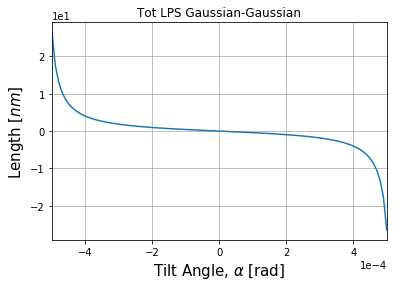

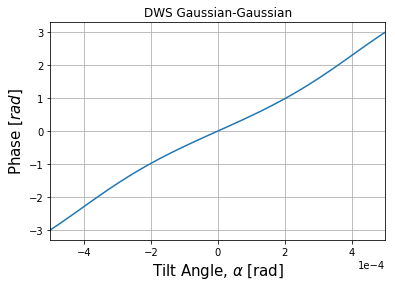

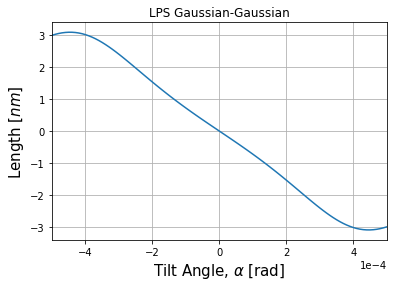

In [13]:
modes_0 = plb.modes((0,0,1))



# z=10e-3
# params = pl.Params(1064e-9,1e-3,z)


print('Signals calculation...')
v = Vars()
dws,lps,total_lps = signals(v)


params=pl.Params(1064e-9,waist,0)
K=params.getK()

total_arr = np.array(total_lps)
total_arr_con = total_arr*1e9

lps_arr = np.array(lps)
lps_arr_con = lps_arr*1e9

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
plt.title(r'Tot LPS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,total_arr_con)


plt.grid()

plt.figure()

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,dws)

plt.grid()

plt.figure()



plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
plt.title(r'LPS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,lps_arr_con)


plt.grid()

In [14]:
# modes_0 = plb.modes((0,0,1))

# x=1
# I=1j

# # z=10e-3
# # params = pl.Params(1064e-9,1e-3,z)



# v = Vars()
# dws,lps,total_lps = signals(v)


# params=pl.Params(1064e-9,waist,0)
# K=params.getK()

# total_arr = np.array(total_lps)
# total_arr_con = total_arr*1e9

# lps_arr = np.array(lps)
# lps_arr_con = lps_arr*1e9

# plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
# plt.title(r'Tot LPS Gaussian-Gaussian') 
# plt.xlim([-300e-6,300e-6])
# # plt.legend()
# plt.plot(v.alpha_arr,total_arr_con)


# plt.grid()

# plt.figure()

# plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# plt.ylabel(r'Phase $[' +  'rad]$', fontsize=15) 
# plt.title(r'DWS Gaussian-Gaussian') 
# plt.xlim([-300e-6,300e-6]); plt.ylim([-2,2])
# # plt.legend()
# plt.plot(v.alpha_arr,dws)

# plt.grid()

# plt.figure()



# plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
# plt.title(r'LPS Gaussian-Gaussian') 
# plt.xlim([-300e-6,300e-6]); plt.ylim([-5,5])
# # plt.legend()
# plt.plot(v.alpha_arr,lps_arr_con)


# plt.grid()

In [15]:
lps = lps_arr_con; total_lps = total_arr_con;

dws_slope = np.zeros(len(dws),np.float)
dws_slope[0:-1] = np.diff(dws)/np.diff(v.alpha_arr)
dws_slope[-1] = (dws[-1] - dws[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])
lps_slope = np.zeros(len(lps),np.float)
lps_slope[0:-1] = np.diff(lps)/np.diff(v.alpha_arr)
lps_slope[-1] = (lps[-1] - lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])
total_lps_slope = np.zeros(len(total_lps),np.float)
total_lps_slope[0:-1] = np.diff(total_lps)/np.diff(v.alpha_arr)
total_lps_slope[-1] = (total_lps[-1] - total_lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])




###############################################
note = ('_'+str(working)+'_'+str(working))

scipy.io.savemat('tophat'+note+'.mat', mdict={'angle': v.alpha_arr, 'lps'+note: lps, 'total_lps'+note: total_lps,'dws_HG00'+note: dws,
                                         'lps_slope'+note: lps_slope, 'total_lps_slope'+note : total_lps_slope,
                                        'dws_slope'+note: dws_slope})

print(v.alpha_arr)

[-5.0e-04 -4.9e-04 -4.8e-04 -4.7e-04 -4.6e-04 -4.5e-04 -4.4e-04 -4.3e-04
 -4.2e-04 -4.1e-04 -4.0e-04 -3.9e-04 -3.8e-04 -3.7e-04 -3.6e-04 -3.5e-04
 -3.4e-04 -3.3e-04 -3.2e-04 -3.1e-04 -3.0e-04 -2.9e-04 -2.8e-04 -2.7e-04
 -2.6e-04 -2.5e-04 -2.4e-04 -2.3e-04 -2.2e-04 -2.1e-04 -2.0e-04 -1.9e-04
 -1.8e-04 -1.7e-04 -1.6e-04 -1.5e-04 -1.4e-04 -1.3e-04 -1.2e-04 -1.1e-04
 -1.0e-04 -9.0e-05 -8.0e-05 -7.0e-05 -6.0e-05 -5.0e-05 -4.0e-05 -3.0e-05
 -2.0e-05 -1.0e-05  0.0e+00  1.0e-05  2.0e-05  3.0e-05  4.0e-05  5.0e-05
  6.0e-05  7.0e-05  8.0e-05  9.0e-05  1.0e-04  1.1e-04  1.2e-04  1.3e-04
  1.4e-04  1.5e-04  1.6e-04  1.7e-04  1.8e-04  1.9e-04  2.0e-04  2.1e-04
  2.2e-04  2.3e-04  2.4e-04  2.5e-04  2.6e-04  2.7e-04  2.8e-04  2.9e-04
  3.0e-04  3.1e-04  3.2e-04  3.3e-04  3.4e-04  3.5e-04  3.6e-04  3.7e-04
  3.8e-04  3.9e-04  4.0e-04  4.1e-04  4.2e-04  4.3e-04  4.4e-04  4.5e-04
  4.6e-04  4.7e-04  4.8e-04  4.9e-04  5.0e-04]


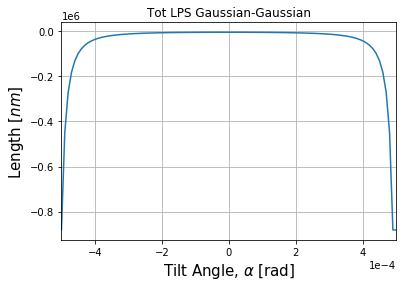

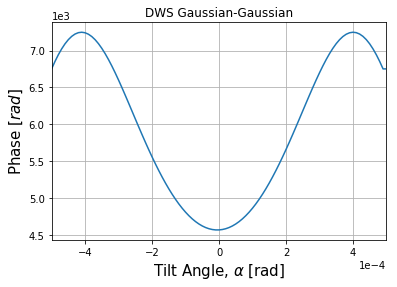

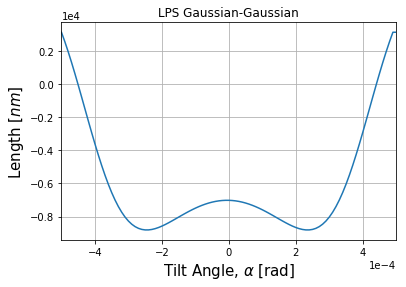

In [16]:
total_arr = np.array(total_lps)
total_arr_con = total_arr*1e9

lps_arr = np.array(lps)
lps_arr_con = lps_arr*1e9

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
plt.title(r'Tot LPS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,total_lps_slope)


plt.grid()

plt.figure()

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,dws_slope)

plt.grid()

plt.figure()



plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
plt.title(r'LPS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,lps_slope)


plt.grid()